In [31]:
# !pip install arcgis

In [32]:
"""Plague Classification Model with ArcGIS Data"""

import os
import shutil
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing import image_dataset_from_directory
from arcgis.gis import GIS
from PIL import Image

In [33]:
# Conexión a ArcGIS Online o Enterprise
gis = GIS("https://arcgismaps.pantaleon.com/portal", "uvg_2024", "Inicio2024.")

In [34]:
# Encuentra el elemento Survey123 por su ID
survey = gis.content.get("e9eff4bf0dff4d199ff5b889d8fd7980")  # Reemplaza con el ID real de tu Survey
feature_layer = survey.layers[0]  # Capa que contiene las respuestas

In [35]:
# Función para verificar si un adjunto es una imagen
def is_image_attachment(attachment):
    return attachment['contentType'] in ['image/png', 'image/jpeg']

In [36]:

# Función para redimensionar las imágenes
def resize_image(image_path):
    with Image.open(image_path) as img:
        img = img.resize((128, 128))
        img.save(image_path)

In [37]:
# Directorio base para almacenar las imágenes descargadas
base_images_dir = "arcgis-survey-images"
if not os.path.exists(base_images_dir):
    os.makedirs(base_images_dir)

In [38]:
# # Descargar imágenes desde Survey123 y organizar en carpetas según la clasificación
# for feature in feature_layer.query().features:
#     object_id = feature.attributes['objectid']
#     classification = feature.attributes['clasificacion']  # Clasificación de la plaga

#     # Crear un directorio para la clasificación si no existe
#     class_dir = os.path.join(base_images_dir, classification)
#     if not os.path.exists(class_dir):
#         os.makedirs(class_dir)
    
#     # Descargar los adjuntos (imágenes) para el object_id
#     attachments = feature_layer.attachments.get_list(oid=object_id)
#     for attachment in attachments:
#         if is_image_attachment(attachment):
#             image_path = os.path.join(class_dir, attachment['name'])
#             feature_layer.attachments.download(oid=object_id, attachment_id=attachment['id'], save_path=class_dir)
#             resize_image(image_path)

# print(f"Imágenes descargadas y organizadas por clasificación en: {base_images_dir}")


In [39]:
# Parámetros de la red
EPOCHS = 50
IMAGE_SIZE = (128, 128)
INPUT_SHAPE = (128, 128, 3)
SEED = 123
BATCH_SIZE = 32
BUFFER_SIZE = 250
LEARNING_RATE = 0.001


images_dir = 'arcgis-survey-images'

In [40]:
# Cargar dataset de imágenes
train_ds = image_dataset_from_directory(
    images_dir,
    labels="inferred",
    batch_size=BATCH_SIZE,
    image_size=IMAGE_SIZE,
    validation_split=0.2,
    subset="training",
    seed=SEED,
    shuffle=True
)

validation_ds = image_dataset_from_directory(
    images_dir,
    labels="inferred",
    batch_size=BATCH_SIZE,
    image_size=IMAGE_SIZE,
    validation_split=0.2,
    subset="validation",
    seed=SEED
)

Found 1874 files belonging to 5 classes.
Using 1500 files for training.
Found 1874 files belonging to 5 classes.
Using 374 files for validation.


In [41]:
# Data Augmentation
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal_and_vertical'),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.1),
    tf.keras.layers.RandomContrast(0.1),
])

In [42]:
augmented_train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y))

In [43]:
class_names = train_ds.class_names

In [44]:
# Cache y prefetch para mejorar rendimiento
train_ds = train_ds.cache().shuffle(BUFFER_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)
validation_ds = validation_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

In [45]:
# Cargar el modelo base (MobileNetV2)
from tensorflow.keras.applications import MobileNetV2

In [46]:
base_model = MobileNetV2(input_shape=INPUT_SHAPE,
                         include_top=False,
                         weights='imagenet')

In [47]:
# Ajuste de las capas del modelo base
for layer in base_model.layers[:100]:  # Ajusta según sea necesario
    layer.trainable = False

In [48]:
# Definir el modelo
model = tf.keras.models.Sequential([
    tf.keras.layers.Rescaling(1./255),
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Dense(len(class_names))
])


In [49]:
# Compilar el modelo
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=LEARNING_RATE,
    decay_steps=10000,
    decay_rate=0.9,
    staircase=True
)

In [50]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [51]:
# Entrenamiento del modelo
history = model.fit(
    augmented_train_ds,
    validation_data=validation_ds,
    epochs=EPOCHS,
)

Epoch 1/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 29s 326ms/step - accuracy: 0.5947 - loss: 2.2678 - val_accuracy: 0.4358 - val_loss: 4.4113
Epoch 2/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 14s 296ms/step - accuracy: 0.7885 - loss: 1.5012 - val_accuracy: 0.4171 - val_loss: 7.8247
Epoch 3/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 17s 368ms/step - accuracy: 0.8203 - loss: 1.1968 - val_accuracy: 0.5107 - val_loss: 3.3891
Epoch 4/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 16s 335ms/step - accuracy: 0.8207 - loss: 1.0179 - val_accuracy: 0.4358 - val_loss: 8.6213
Epoch 5/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 15s 311ms/step - accuracy: 0.8410 - loss: 0.8397 - val_accuracy: 0.6952 - val_loss: 2.9759
Epoch 6/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 15s 313ms/step - accuracy: 0.8481 - loss: 0.7016 - val_accuracy: 0.7567 - val_loss: 1.8986
Epoch 7/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 15s 306ms/step - accuracy: 0.8694 - loss: 0.6058 - val_accuracy: 0.6818 - val_loss: 2.5562
Epoch 8/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 15s 326ms/step - accuracy: 0.8533 - loss: 0.5919 - val_accu

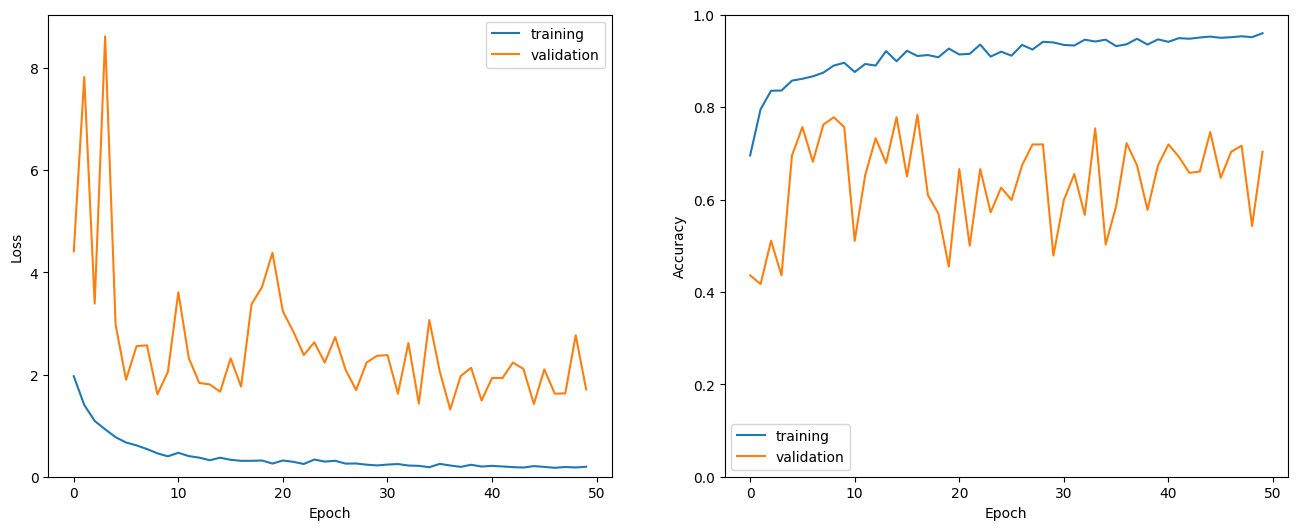

In [52]:
# Gráfica de la pérdida y precisión
metrics = history.history
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['training', 'validation'])
plt.ylim([0, max(plt.ylim())])
plt.ylabel('Loss')
plt.xlabel('Epoch')

plt.subplot(1, 2, 2)
plt.plot(history.epoch, metrics['accuracy'], metrics['val_accuracy'])
plt.legend(['training', 'validation'])
plt.ylim([0, 1])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.show()

In [53]:
# Evaluación en el conjunto de test
test_ds = validation_ds.shard(num_shards=2, index=1)
test_results = model.evaluate(test_ds, return_dict=True)
print("Resultados de evaluación en test set:")
for metric, value in test_results.items():
    print(f"{metric}: {value:.4f}")

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step - accuracy: 0.6621 - loss: 1.8282
Resultados de evaluación en test set:
accuracy: 0.6758
loss: 1.8574


6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 367ms/step


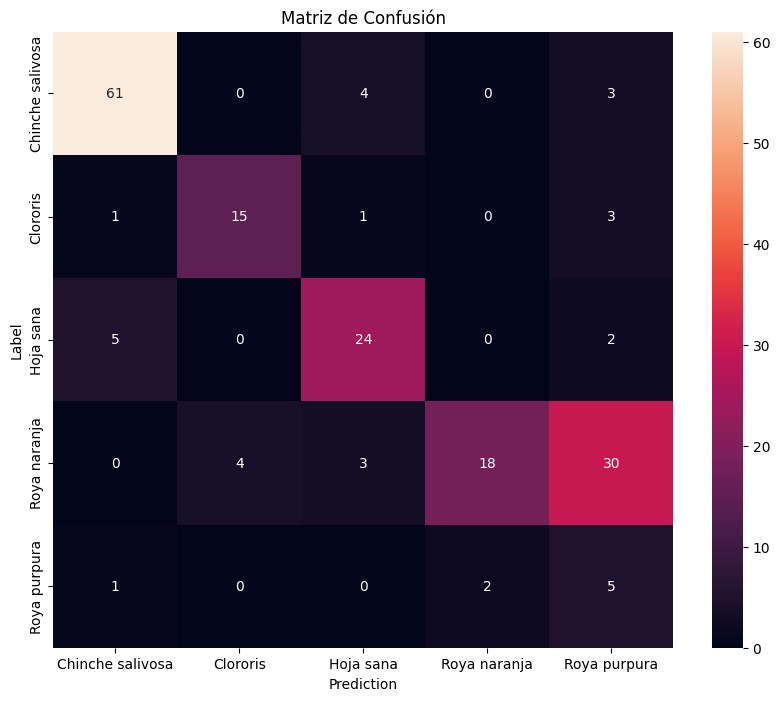

In [54]:
# Matriz de confusión
y_pred = model.predict(test_ds)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.concatenate([y for x, y in test_ds], axis=0)

conf_matrix = tf.math.confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, xticklabels=class_names, yticklabels=class_names, annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.title('Matriz de Confusión')
plt.show()


In [55]:
# Reporte de clasificación
from sklearn.metrics import classification_report
print("Reporte de clasificación:")
print(classification_report(y_true, y_pred_classes, target_names=class_names))

Reporte de clasificación:
                  precision    recall  f1-score   support

Chinche salivosa       0.90      0.90      0.90        68
        Clororis       0.79      0.75      0.77        20
       Hoja sana       0.75      0.77      0.76        31
    Roya naranja       0.90      0.33      0.48        55
    Roya purpura       0.12      0.62      0.20         8

        accuracy                           0.68       182
       macro avg       0.69      0.67      0.62       182
    weighted avg       0.83      0.68      0.70       182

